<a href="https://colab.research.google.com/github/kiran2424/Live-Class-Monitoring-System-Face-emotion-Recognition-/blob/main/Captstone_Project_5_Live_Class_Monitoring_System_%5BFace_emotion_Recognition%5D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**
# **Introduction**

---


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.


Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.


In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# **Objective**

---


Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**

---


We have utilized the FER 2013 dataset provided on Kaggle.
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 

# **Importing Libraries**

In [ ]:
# Importing necessory libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,MaxPooling2D,Flatten,Conv2D,BatchNormalization,Activation
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools
import datetime



# **Importing Data**

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Live Class Monitoring System [Face emotion Recognition]/FER 2013 Dataset.zip'

In [ ]:
# Importing and extracted the zip file data
from zipfile import ZipFile
with ZipFile(path , 'r') as zip_file:
  zip_file.extractall()
  print('Done!')

Done!


In [ ]:
print (len(zip_file.namelist()))


35887


So we have total 35887 images in our data set which includes all categories of emotions

To divide the data into test and train, we have to look into the format of our data. Let's find out...

In [ ]:
#first 10 extracted file name and its format
for file in (zip_file.namelist()[:10]):
  print(file)

test/angry/PrivateTest_10131363.jpg
test/angry/PrivateTest_10304478.jpg
test/angry/PrivateTest_1054527.jpg
test/angry/PrivateTest_10590091.jpg
test/angry/PrivateTest_1109992.jpg
test/angry/PrivateTest_11296953.jpg
test/angry/PrivateTest_12000629.jpg
test/angry/PrivateTest_12008383.jpg
test/angry/PrivateTest_12191716.jpg
test/angry/PrivateTest_1221822.jpg


So we are using the above path format

**Seperating the training and testing data**

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'


**Let's visualize our data**

Few images from train dataset are...


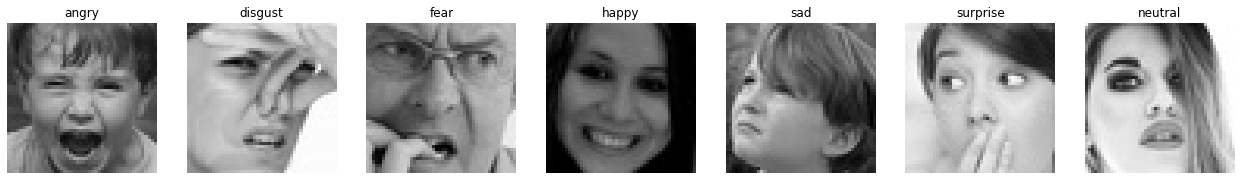

Few images from test dataset are...


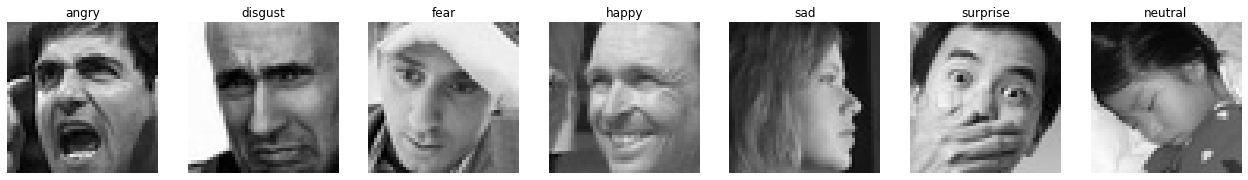

In [ ]:
img_size = 48
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print('Few images from train dataset are...')

plt.figure(figsize=(22,24))
i = 1
for expression in emotion_list:
  img_train = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[30]))
  plt.subplot(1,7,i)
  plt.imshow(img_train)
  plt.title(expression)
  plt.axis('off')
  i += 1
plt.show()

print('Few images from test dataset are...')

plt.figure(figsize=(48,48))
j=1
for expression in emotion_list:
  img_test = load_img((test_dir + '/' + expression +'/'+ os.listdir(test_dir + '/' + expression)[30]))
  plt.subplot(1,15,j)
  plt.imshow(img_test)
  plt.title(expression)
  plt.axis('off')
  j += 1
plt.show()



# **Data Preprocessing**

Before we proceed we need to rescale our data by multiplying it by 1/255 and it will convert out data's pixel value between 0 to 1

In [ ]:
#Normalize pixel value between 0 to 1
train_datagen = ImageDataGenerator(rescale=1./255)
                                   
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_datagen

Next, let's do data augmentation for better results

In [ ]:
img_size = 48
batch_size = 64

# Training data.
training_set = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=True
                                              )

# Validation data.
test_set = test_datagen.flow_from_directory(directory=test_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=False
                                              )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# **Applying CNN method**

**Let's create our custom CNN model**

In [ ]:
# First layer
from keras.regularizers import l2

model= tf.keras.models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1),kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3, 3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer
model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer   
model.add(Conv2D(256,(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth layer
model.add(Conv2D(512,(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# First fully connected layer
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

# Second fully connected layer  
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )
print('CNN model has been created successfully')


CNN model has been created successfully


In [ ]:
# Model summary
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization_15 (Bat  (None, 24, 24, 64)      

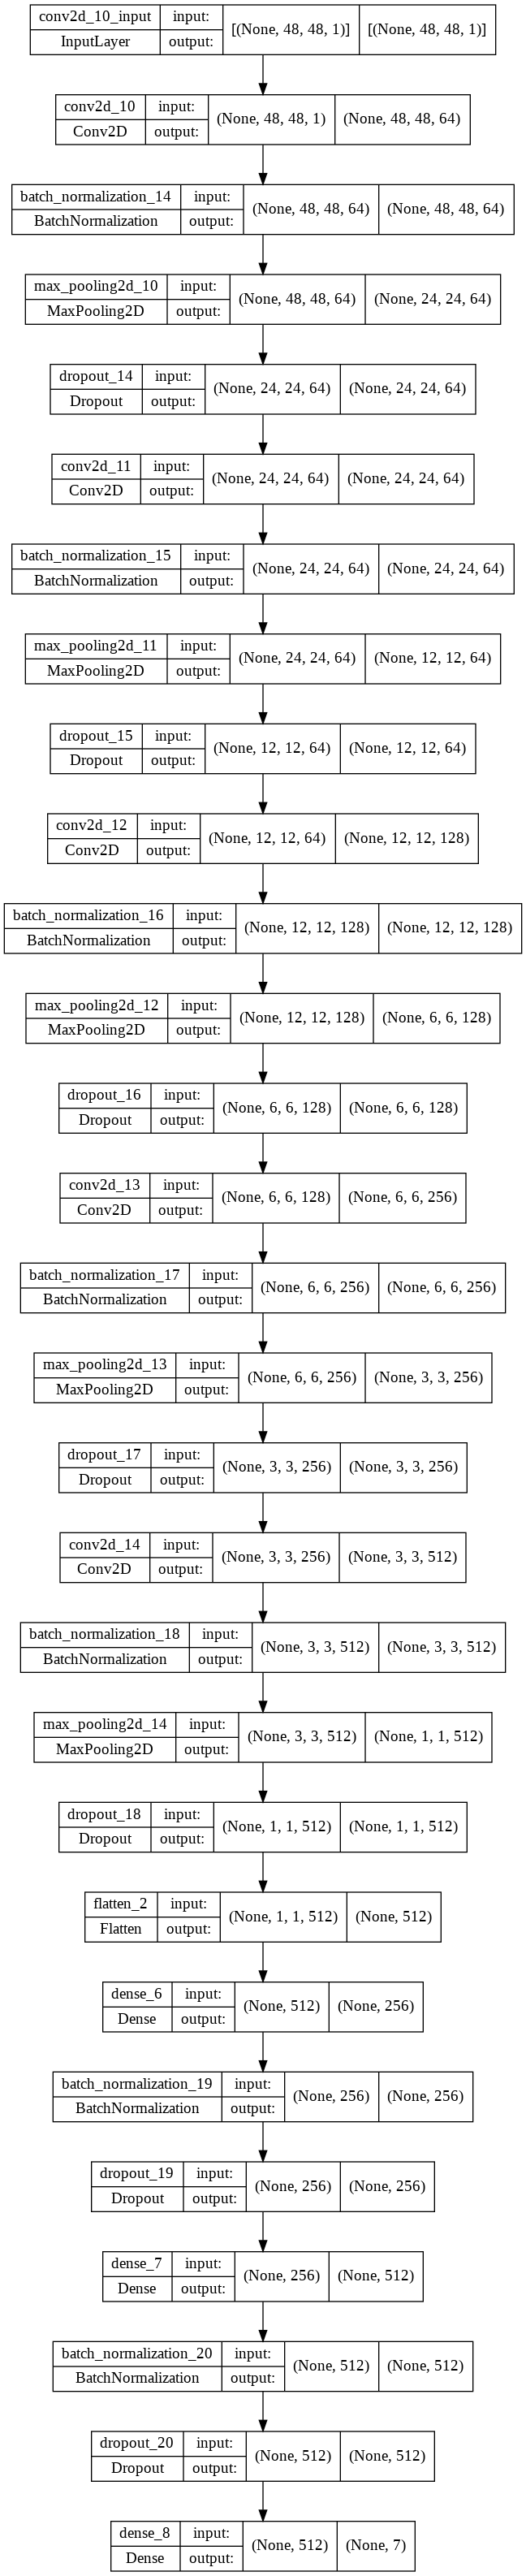

In [ ]:
#vizualization of model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Fitting our model
history = model.fit_generator(generator = training_set,
                              steps_per_epoch=training_set.n//training_set.batch_size,
                              validation_data = test_set,
                              validation_steps=test_set.n//test_set.batch_size,
                              epochs = 30)

print('Your model has been trained!!')


Epoch 1/30
448/448 [==============================] - 417s 928ms/step - loss: 2.1246 - accuracy: 0.2132 - val_loss: 2.5144 - val_accuracy: 0.2508
Epoch 2/30
448/448 [==============================] - 414s 924ms/step - loss: 1.7380 - accuracy: 0.3268 - val_loss: 1.7531 - val_accuracy: 0.3005
Epoch 3/30
448/448 [==============================] - 416s 928ms/step - loss: 1.5076 - accuracy: 0.4207 - val_loss: 1.5152 - val_accuracy: 0.4164
Epoch 4/30
448/448 [==============================] - 415s 925ms/step - loss: 1.3889 - accuracy: 0.4712 - val_loss: 1.3658 - val_accuracy: 0.4773
Epoch 5/30
448/448 [==============================] - 416s 930ms/step - loss: 1.3186 - accuracy: 0.4979 - val_loss: 1.2980 - val_accuracy: 0.5066
Epoch 6/30
448/448 [==============================] - 414s 924ms/step - loss: 1.2489 - accuracy: 0.5281 - val_loss: 1.4372 - val_accuracy: 0.4865
Epoch 7/30
448/448 [==============================] - 416s 928ms/step - loss: 1.2076 - accuracy: 0.5442 - val_loss: 1.2248 -

We have applied till 30 epochs and got accuracy of 80.96% in training data & 63.09% in testing data.

The loss also decreased from 2.12 to 0.54 in training data and from 2.51 to 1.27 in testing data

# **Model Evaluation**

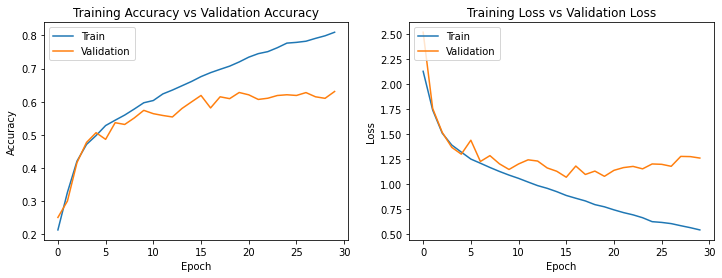

In [ ]:
# Create plots for accuracy and loss.
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

<Figure size 432x288 with 0 Axes>

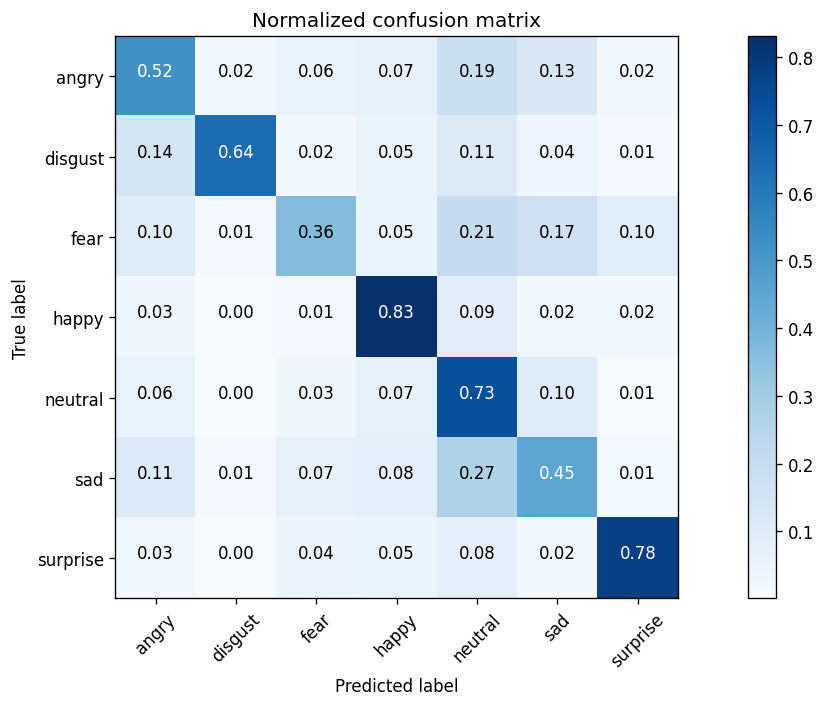

In [ ]:
# Create confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

# Create function to plot confussion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

With the matrix, we can analyze why the model performs poorly on 'fear' by looking at the row of confusion matrix

Ah, it is clear now. Most ‘fear’ faces are incorrectly predicted as angry, sad or neutral. 

# **Let's test our model**

(48, 48)


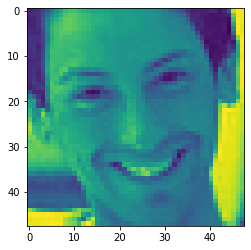

In [ ]:
img = image.load_img("/content/train/happy/Training_371241.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}


In [ ]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[1.6149664e-20, 2.439993e-36, 0.0, 1.0, 1.8555509e-33, 4.200219e-19, 1.3918004e-35]


In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Happy


Saving the model for webapp in h5 format

In [ ]:
model.save('model.h5')


In [ ]:
model.save_weights('model_weights.h5')


# **Conclusion**

* We started by uploading the FER 2013 dataset from kaggle to solve out problem statement of recognising the emotions in live webcam.

* Then we splitted our data into trining and testing sets followed by converting it between 0 to 1 pixel size by multiplying with 1/255.

* We build a CNN model which is capable of recognition the facial expression of the user.

* The model obtained accuracy of 80.96% in training data & 63.09% in testing data and the loss also decreased from 2.12 to 0.54 in training data and from 2.51 to 1.27 in testing data.

* From the confussion matrix we saw that our model does a good job in predicting most of the classes but the performance is comparatively lower in class fear. Most ‘fear’ faces are incorrectly predicted as angry, sad or neutral. 

* Finally, we tested the model by using an image from the dataset and it predicted it correctly.




